Ссылка на данные\
https://www.kaggle.com/datasets/alistairking/weather-long-term-time-series-forecasting/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.fft import fft, fftfreq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

# Расшифровка наименований признаков

В датасете содержатся записи за каждые 10 минут измерений погодных условий в Гейдельберге (Метеостанция института Макса Планка)

| Аббревиатура | Описание |
|--------------|----------|
| date | Дата и время наблюдения. |
| p | Атмосферное давление в миллибарах (mbar). |
| T | Температура воздуха в градусах Цельсия (°C). |
| Tpot | Потенциальная температура в Кельвинах (K) - температура, которую имела бы воздушная масса при перемещении на стандартный уровень давления. |
| Tdew | Температура точки росы в градусах Цельсия (°C) - температура насыщения воздуха влагой. |
| rh | Относительная влажность в процентах (%) - отношение текущей влажности к максимально возможной при данной температуре. |
| VPmax | Максимальное давление водяного пара в миллибарах (mbar) - предельное давление пара при заданной температуре. |
| VPact | Актуальное давление водяного пара в миллибарах (mbar) - текущее давление пара в воздухе. |
| VPdef | Дефицит давления пара в миллибарах (mbar) - разница между VPmax и VPact (показатель потенциала высыхания). |
| sh | Удельная влажность в граммах на килограмм (g/kg) - масса водяного пара на кг воздуха. |
| H2OC | Концентрация водяного пара в миллимолях на моль сухого воздуха (mmol/mol). |
| rho | Плотность воздуха в граммах на кубический метр (g/m³) - масса воздуха на единицу объема. |
| wv | Скорость ветра в метрах в секунду (m/s) - горизонтальное движение воздуха. |
| max.wv | Максимальная скорость ветра в метрах в секунду (m/s) - пиковое значение за период наблюдений. |
| wd | Направление ветра в градусах (°) - направление, откуда дует ветер. |
| rain | Сумма осадков в миллиметрах (mm) - общее количество дождя за период наблюдений. |
| raining | Продолжительность дождя в секундах (s) - время выпадения осадков. |
| SWDR | Коротковолновая нисходящая радиация в ваттах на квадратный метр (W/m²) - входящая солнечная радиация. |
| PAR | Фотосинтетически активная радиация в микромолях на м²/с (µmol/m²/s) - свет, доступный для фотосинтеза. |
| max.PAR | Максимальная фотосинтетически активная радиация за период наблюдений (µmol/m²/s). |
| Tlog | Температура (логированная) в градусах Цельсия (°C) - данные сенсора/логгера. |
| OT | Операционная метка времени (Operational Timestamp) или временное смещение (уточняется в контексте данных). |

# Загрузка датасета

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('cleaned_weather.csv')

Перевод единиц измерения Кельвинов в Цельсия признака Tpot

In [3]:
df.loc[:,'Tpot'] = df['Tpot'].apply(lambda x: x-273.15)

In [4]:
df.head(6)

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,0.03,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,0.07,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,0.06,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,-0.29,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,-0.33,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81
5,2020-01-01 01:00:00,1008.44,0.34,-0.31,-1.54,87.1,6.26,5.45,0.81,3.37,5.41,1281.84,0.63,1.32,188.0,0.0,0.0,0.0,0.0,0.0,11.91


# Описательная статистика данных

Рассмотрение графиков распределения значений записей данных, корреляции признаков. 

In [5]:
df.drop(columns='date').describe()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,10.818241,11.646938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,9.782341,1210.882855,1.995935,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206
std,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,4.082684,36.430222,43.596931,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620
min,955.580000,-6.440000,-6.960000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,2.090000,1107.380000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000
25%,984.800000,4.590000,5.400000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,6.530000,1183.900000,1.000000,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000
50%,990.920000,10.230000,11.170000,5.260000,75.400000,12.480000,8.890000,2.740000,5.610000,8.990000,1210.800000,1.770000,3.000000,195.500000,0.000000,0.000000,2.820000,9.670000,13.120000,20.440000
75%,995.930000,16.180000,17.110000,9.700000,87.900000,18.420000,12.050000,6.440000,7.620000,12.200000,1236.550000,2.920000,4.850000,226.700000,0.000000,0.000000,182.900000,366.437500,434.260000,26.822500
max,1020.070000,34.800000,35.980000,20.500000,100.000000,55.670000,24.160000,42.100000,15.400000,24.530000,1318.520000,13.770000,22.900000,360.000000,11.200000,600.000000,1115.290000,2131.760000,2498.940000,49.090000


Построение гистограмм для всех числовых столбцов

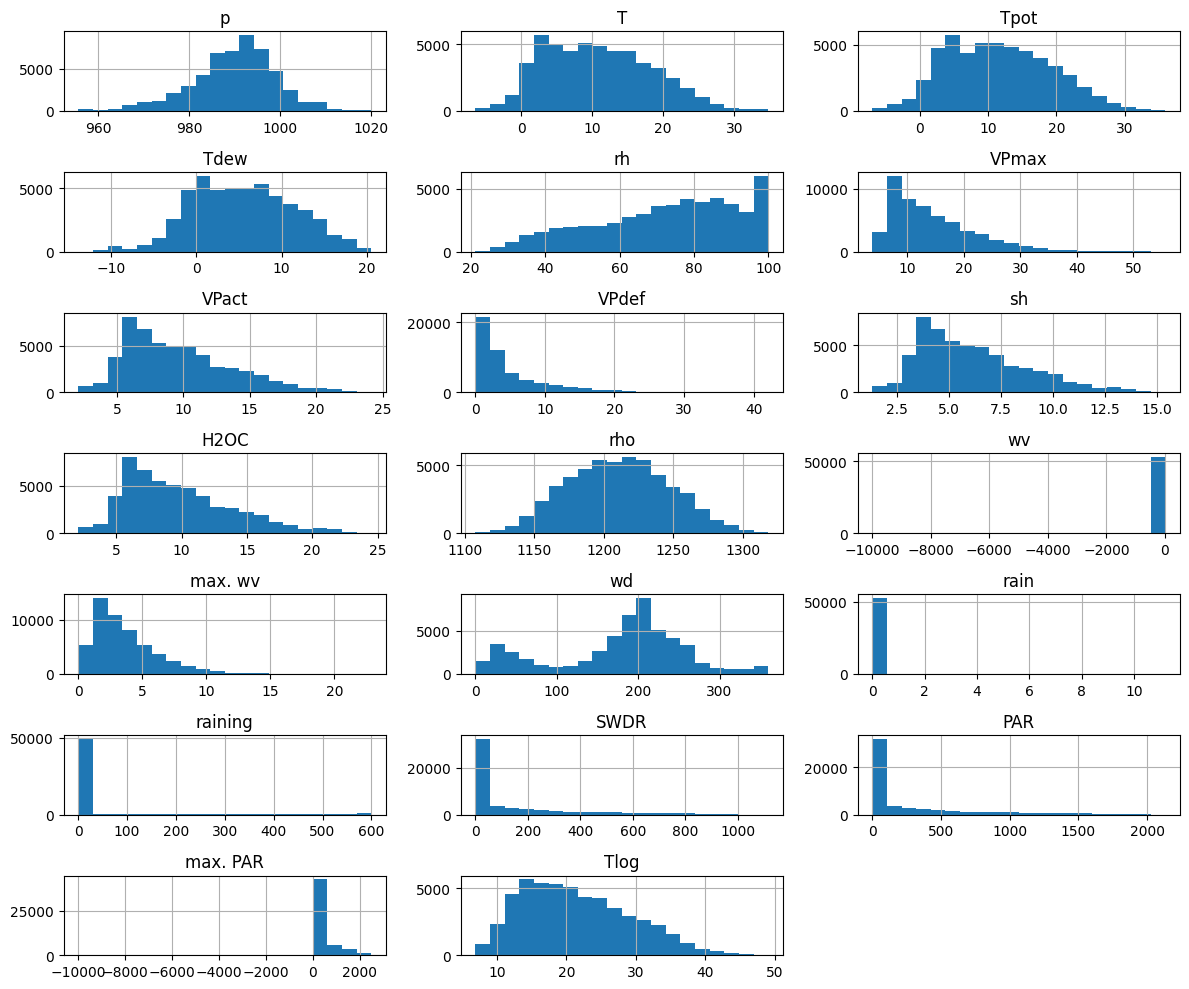

In [6]:
df.drop(columns=['date']).hist(figsize=(12, 10), bins=20, layout=(-1, 3))
plt.tight_layout()
plt.show()

Матрица корреляций

In [7]:
corr = df.drop(columns=['date']).corr()
corr.style.background_gradient(cmap='coolwarm')

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
p,1.000000,-0.127305,-0.223450,-0.207280,-0.068386,-0.098905,-0.183765,-0.002805,-0.200955,-0.201174,0.437434,-0.010172,-0.229759,-0.129084,-0.071890,-0.135033,0.073811,0.067915,0.048888,-0.082453
T,-0.127305,1.000000,0.995228,0.782740,-0.540784,0.967901,0.762860,0.779616,0.761550,0.761934,-0.946510,0.007514,0.109162,-0.061356,0.008448,-0.048777,0.448607,0.459806,0.399064,0.981562
Tpot,-0.223450,0.995228,1.000000,0.789478,-0.524880,0.961013,0.767773,0.766556,0.768193,0.768590,-0.973132,0.008397,0.130117,-0.047439,0.015404,-0.034742,0.433570,0.445155,0.387362,0.972736
Tdew,-0.207280,0.782740,0.789478,1.000000,0.087203,0.712665,0.977413,0.272064,0.976878,0.977256,-0.798148,0.000130,-0.110783,0.022842,0.069465,0.094311,0.104446,0.117344,0.106536,0.741963
rh,-0.068386,-0.540784,-0.524880,0.087203,1.000000,-0.561612,0.085528,-0.836007,0.086812,0.086729,0.440074,-0.012581,-0.347825,0.115019,0.087426,0.228862,-0.558295,-0.558661,-0.483217,-0.558603
VPmax,-0.098905,0.967901,0.961013,0.712665,-0.561612,1.000000,0.712554,0.860390,0.711273,0.711482,-0.900199,0.006312,0.095102,-0.068674,-0.001426,-0.062691,0.466474,0.478430,0.412244,0.962748
VPact,-0.183765,0.762860,0.767773,0.977413,0.085528,0.712554,1.000000,0.255506,0.999814,0.999816,-0.771779,-0.000390,-0.122343,0.013970,0.073675,0.089040,0.101192,0.113418,0.100975,0.727446
VPdef,-0.002805,0.779616,0.766556,0.272064,-0.836007,0.860390,0.255506,1.000000,0.253875,0.254162,-0.679846,0.008982,0.219911,-0.104771,-0.055481,-0.151059,0.569282,0.576877,0.494714,0.798241
sh,-0.200955,0.761550,0.768193,0.976878,0.086812,0.711273,0.999814,0.253875,1.000000,0.999997,-0.776002,-0.000211,-0.117849,0.016267,0.075156,0.091335,0.099126,0.111392,0.099406,0.725602
H2OC,-0.201174,0.761934,0.768590,0.977256,0.086729,0.711482,0.999816,0.254162,0.999997,1.000000,-0.776427,-0.000203,-0.117755,0.016316,0.075122,0.091395,0.099238,0.111511,0.099524,0.725934


"Роза ветров"

In [8]:
# ser = df.groupby('wd_name').count().p.to_frame()
# ser = ser.reset_index()
# sns.scatterplot(x=ser['wd_name'], y=ser.p)

Вычленим из datetime отдельные месяцы, недели, дни...

In [9]:
df.date = pd.to_datetime(df.date)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

Добавим в качестве признака направление ветра в румбах

In [10]:
df.loc[:, 'wd'] = df['wd'] % 360

directions = [
    'С', 'ССВ', 'СВ', 'ВСВ', 'В', 'ВЮВ', 'ЮВ', 'ЮЮВ',
    'Ю', 'ЮЮЗ', 'ЮЗ', 'ЗЮЗ', 'З', 'ЗСЗ', 'СЗ', 'ССЗ'
]

def degrees_to_direction(angle):
    index = int((angle + 11.25) / 22.5) % 16
    return directions[index]

df['wd_name'] = df['wd'].apply(degrees_to_direction)

Посмотрим распределение направления ветра в зависимости от месяца

<Axes: xlabel='wd_name', ylabel='month'>

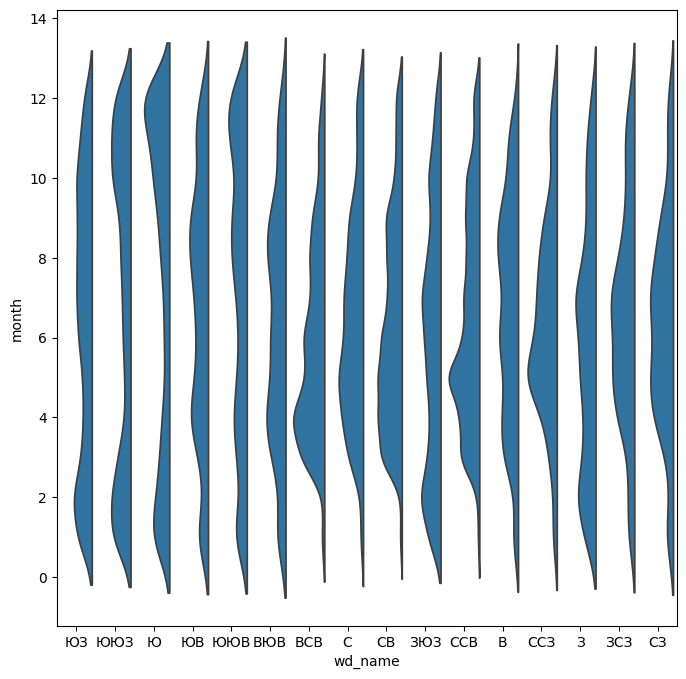

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(data=df, x="wd_name", y="month",split=True, inner=None, ax=ax)

Можно сделать вывод, что южные ветра дуют преимущественно в начале и конце года, а северные - в середине

Применим дискретное преобразование Фурье для анализа спектра фукнции(временного ряда). Это может помочь выявить периодичность, закономерность в данных

In [12]:
SAMPLING_INTERVAL = 10  # минуты дельты записей
SAMPLES_PER_DAY = int((24*60)/SAMPLING_INTERVAL)  # 24ч * 60мин / 10мин = количестов записей за 1 день
SAMPLES_PER_WEEK = int((7*24*60)/SAMPLING_INTERVAL)
SAMPLES_PER_MONTH = int(((365/12)*24*60)/SAMPLING_INTERVAL)

In [13]:
def visualise_fft(series, feature_name, key):
    if key == 'month':
        samples = SAMPLES_PER_MONTH
    elif key == 'week':
        samples = SAMPLES_PER_WEEK
    else:
        samples = SAMPLES_PER_DAY

    n = len(series)
    y = series.values
    
    y_normalized = y - y.mean()     # Центрирование данных.
                                    # Избавление "засоряющего" спектр колебания на частоте 0Гц. Колебания на 0 частоте не изменяются со временем, 
                                    # при преобразовании Фурье будут иметь значения среднего по ряду.
    yf = fft(y_normalized)          # Применяя быстрое преобразование Фурье, получаем массив комплексных значений - информация о частотах спектра
    xf = fftfreq(n, d=1/samples)    # Возвращает массив - частота в циклах/ед.измерения

    amplitudes = (2 * np.abs(yf[:n//2]))/n      # Вычисление величины амплитуд, путем взятия модуля комплексного числа. Мнимая часть отвечает за сходство с синусом, а Re часть, за сходство с косинусом.
                                                # Взятие первой половины, поскольку, по ?теореме Найквиста?, можно выделить не более чем [(частота дискретизации)/2] частот без перекрытия частотами друг друга(aliasing)
                                                # Умножение на 2 для компенсации; деление на n для нормализации
    frequencies = xf[:n//2]
    
    # Поиск доминирующих частот в спектре
    idx = np.argsort(amplitudes)[::-1]
    top_freq = frequencies[idx[:5]]
    top_amp = amplitudes[idx[:5]]
    
    # График
    plt.figure(figsize=(12, 5))
    plt.plot(frequencies, amplitudes)
    plt.scatter(top_freq, top_amp, color='red')
    plt.title(f'Спектр признака {feature_name}')
    plt.xlabel('Частота Гц')
    plt.ylabel('Амплитуда')
    plt.xlim(0, 4)
    plt.grid()
    plt.show()
    
    print(f"\nДоминирующие частоты для {feature_name}:")
    for freq, amp in zip(top_freq, top_amp):
        if freq > 0:
            period = 1/freq
            print(f"{freq:.4f} Гц \t период: {period:.4f} {key} \t Амплитуда: {amp:.4f}")

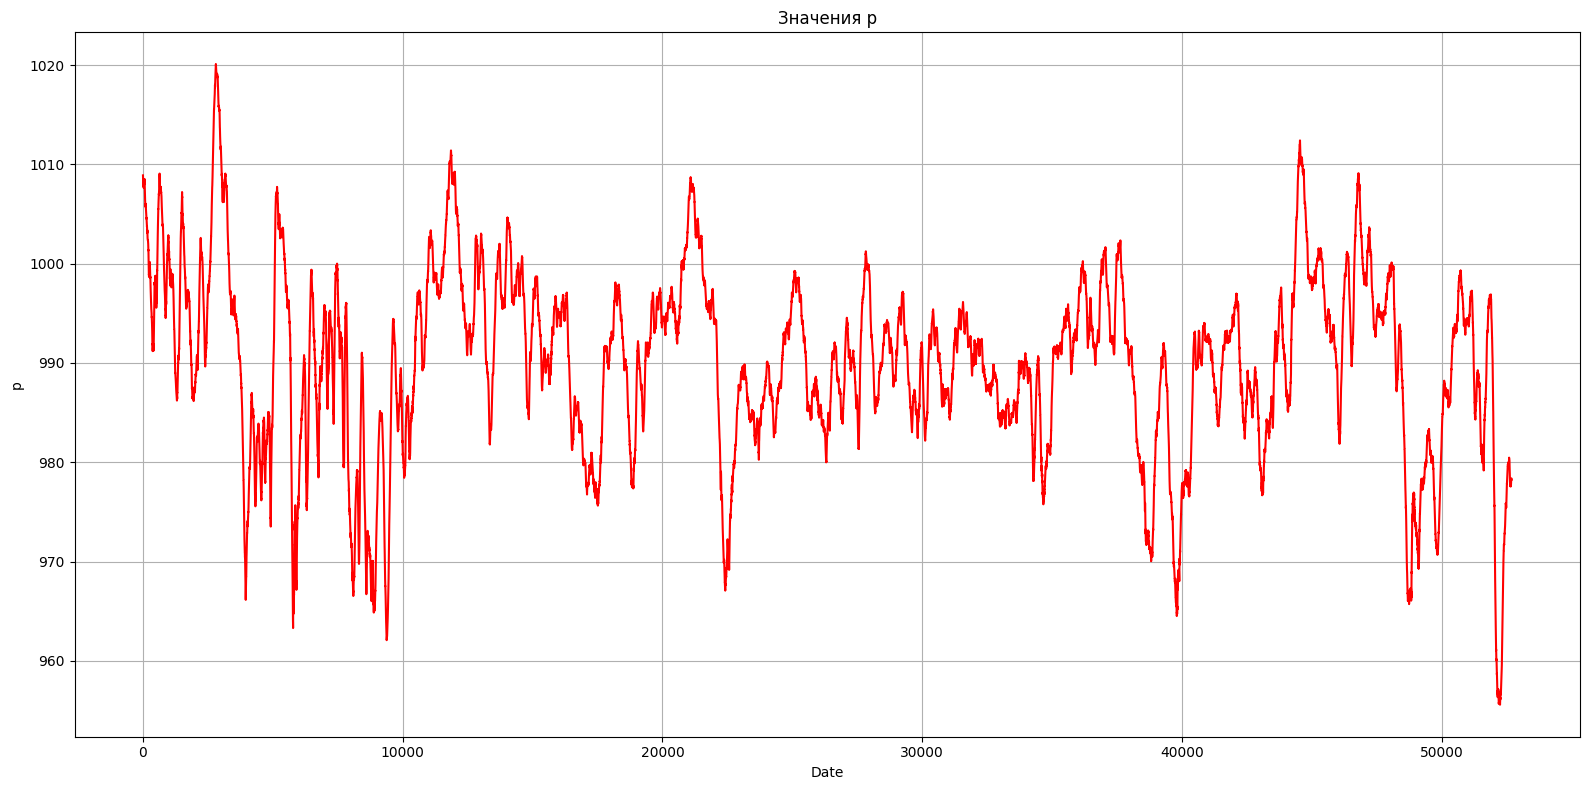

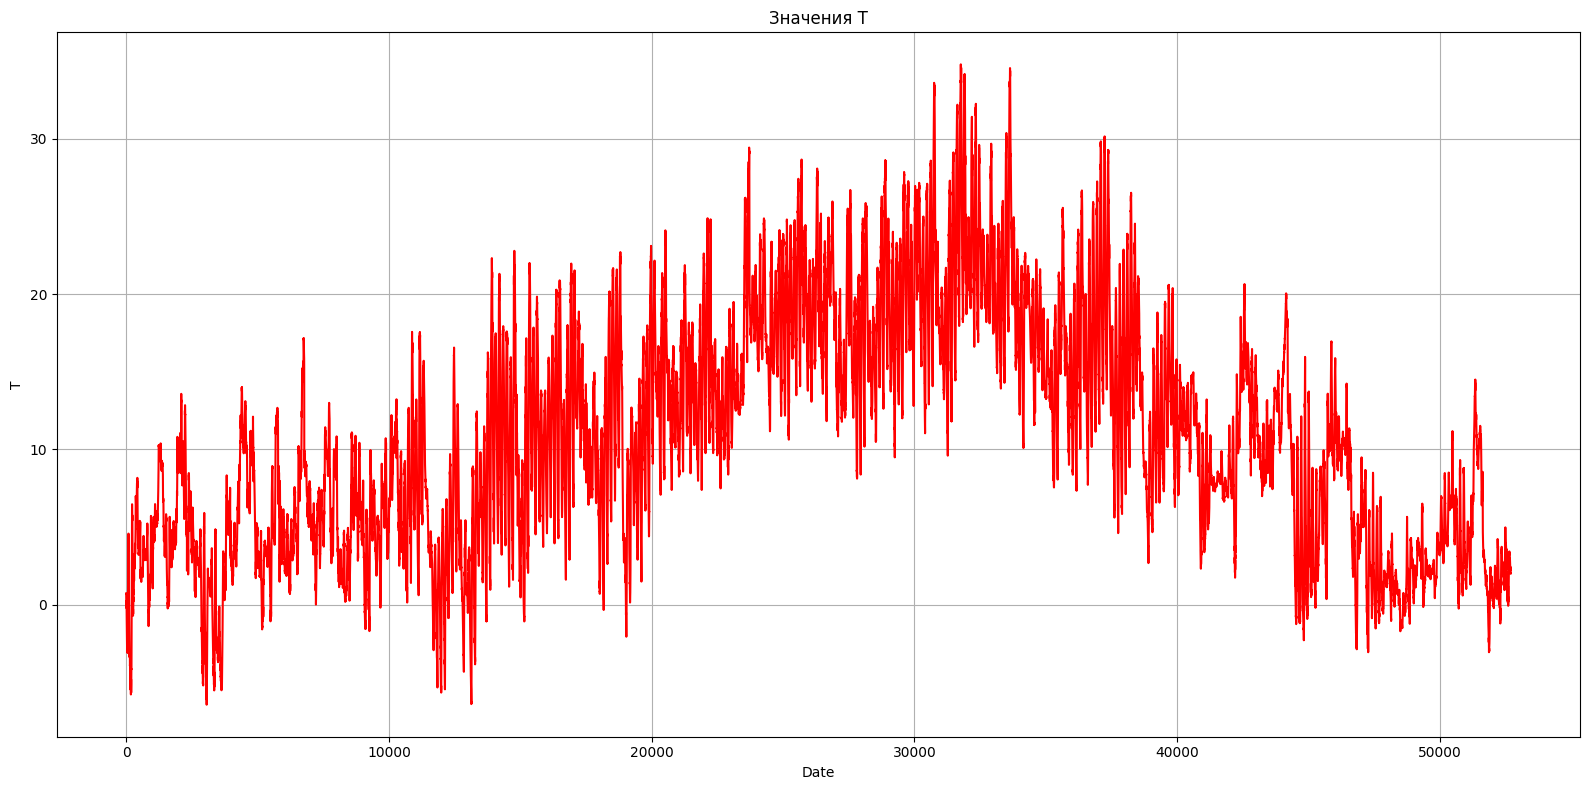

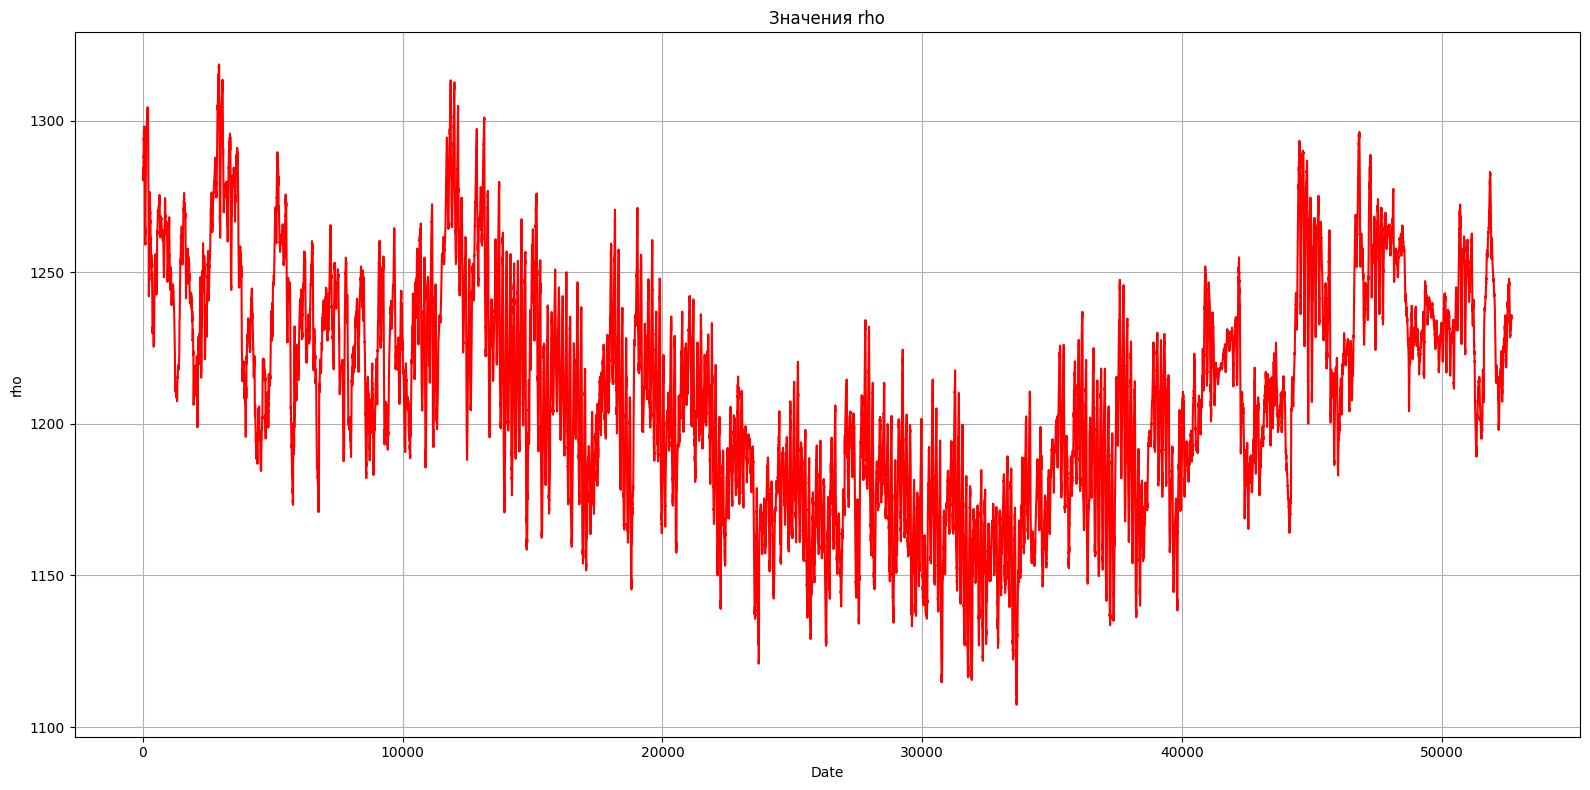

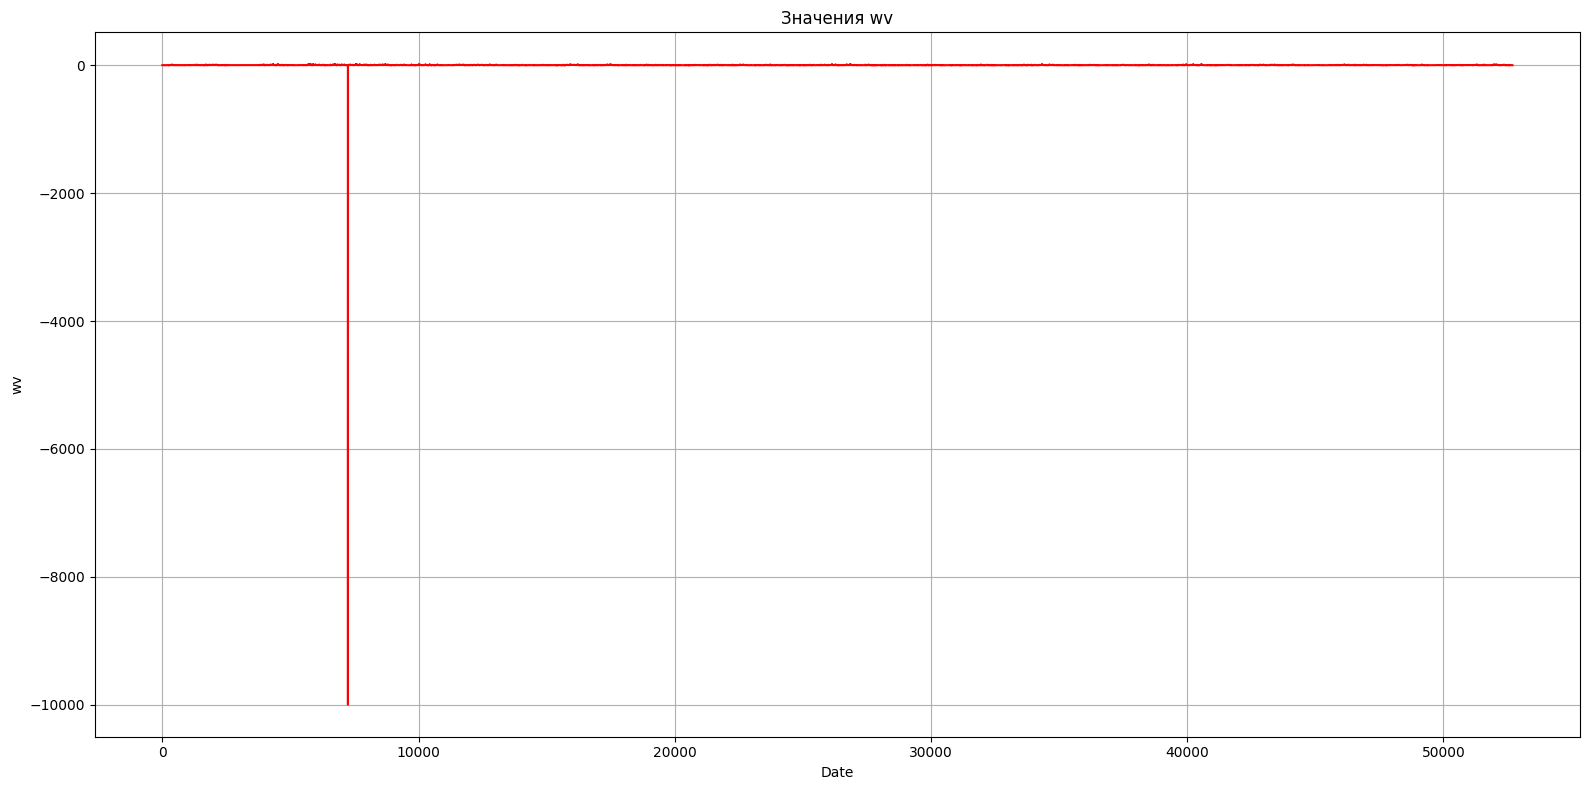

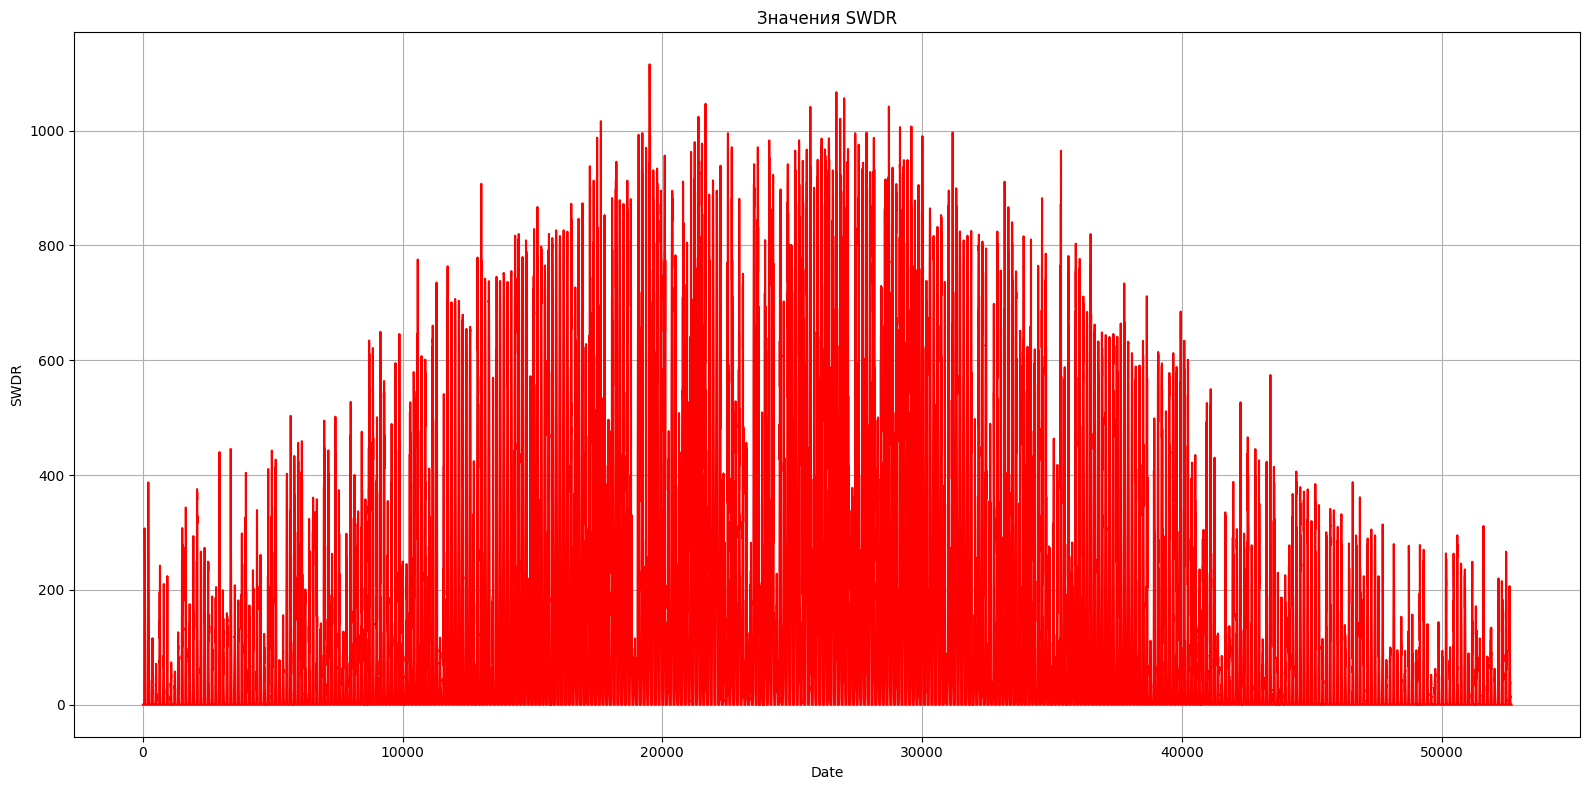

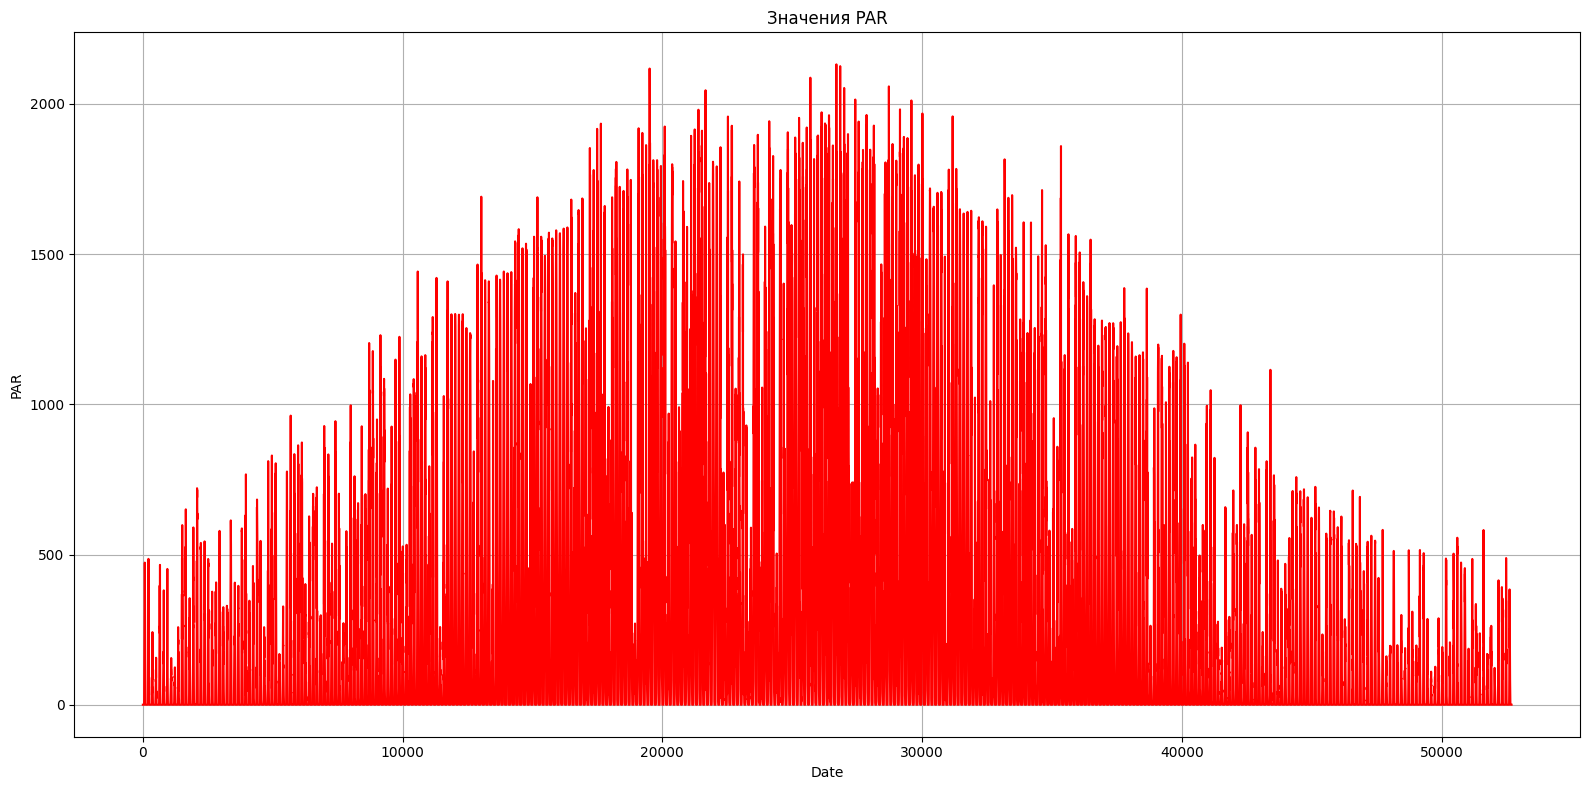

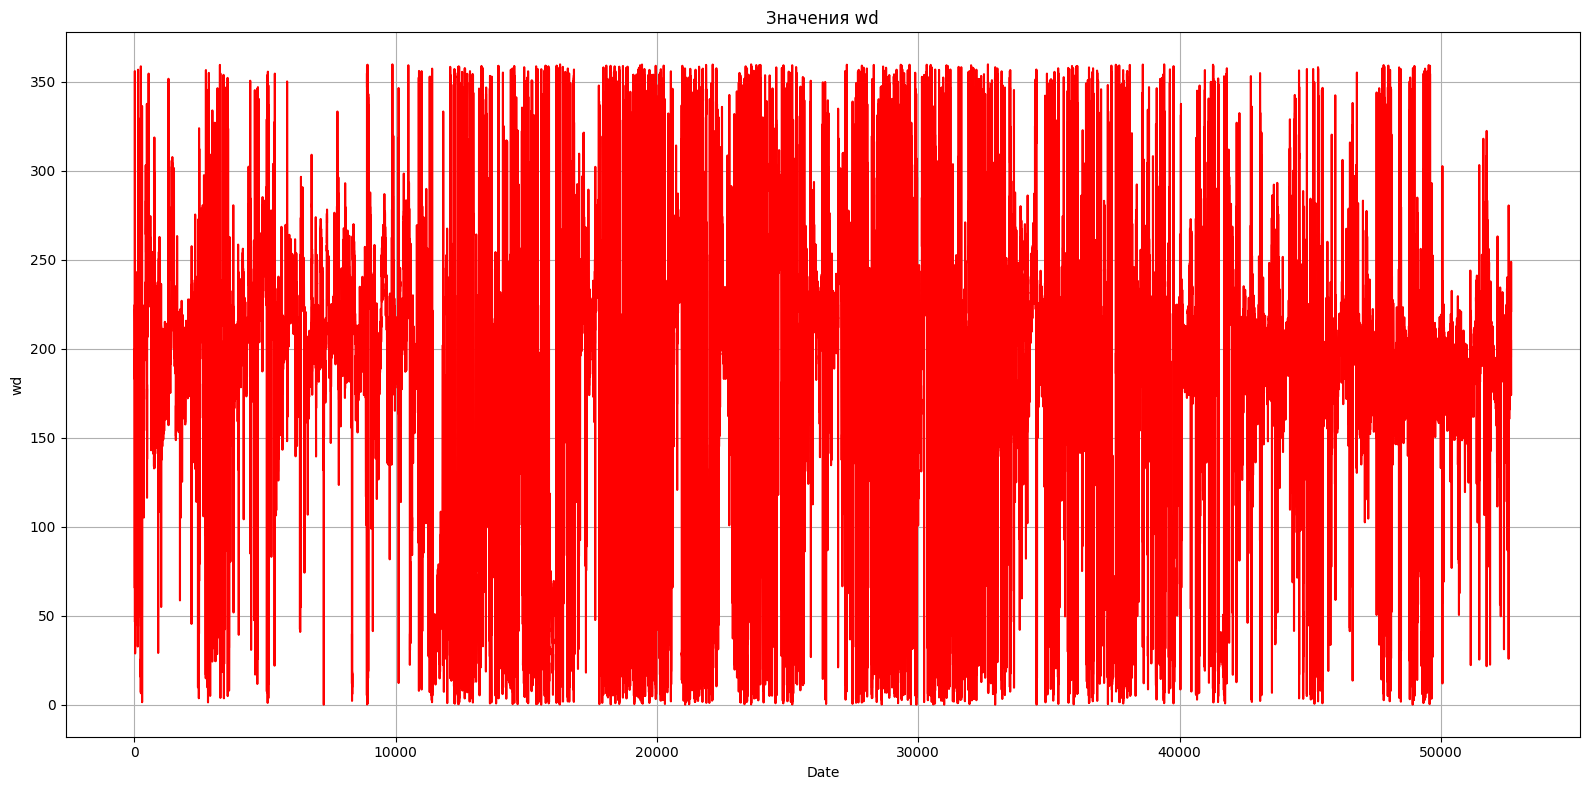

In [14]:
valid_cols = ['p', 'T', 'rho', 'wv', 'SWDR', 'PAR', 'wd']
features_to_viz = valid_cols

for feature in features_to_viz:
    plt.figure(figsize=(16, 8))
    plt.plot(df[feature], linestyle='-', color='red')

    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.grid(True)
    plt.title(f'Значения {feature}')

    plt.tight_layout()
    plt.show()

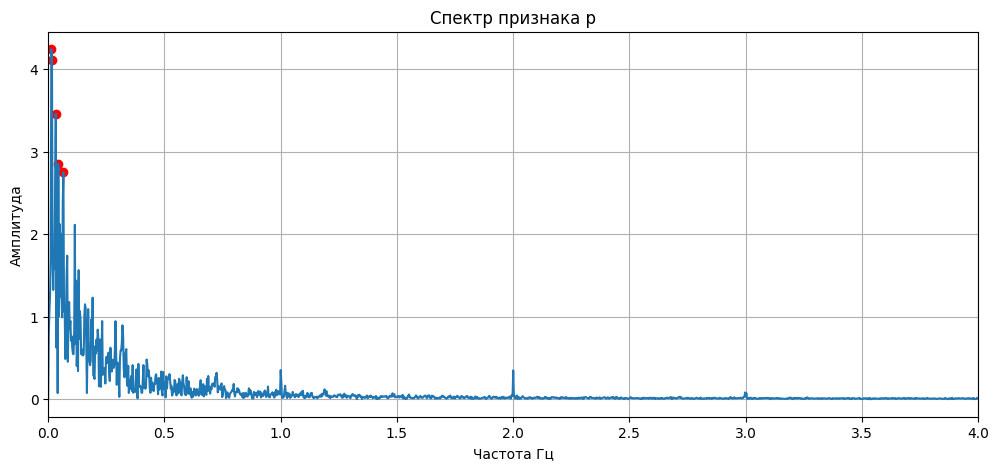


Доминирующие частоты для p:
0.0137 Гц 	 период: 73.1889 day 	 Амплитуда: 4.2428
0.0164 Гц 	 период: 60.9907 day 	 Амплитуда: 4.1105
0.0328 Гц 	 период: 30.4954 day 	 Амплитуда: 3.4602
0.0437 Гц 	 период: 22.8715 day 	 Амплитуда: 2.8518
0.0656 Гц 	 период: 15.2477 day 	 Амплитуда: 2.7506


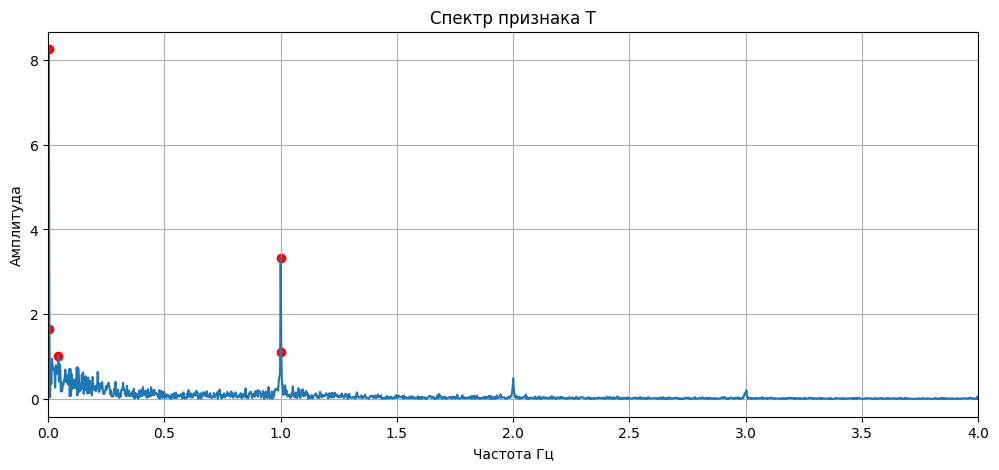


Доминирующие частоты для T:
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 8.2459
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 3.3385
0.0055 Гц 	 период: 182.9722 day 	 Амплитуда: 1.6433
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 1.1141
0.0437 Гц 	 период: 22.8715 day 	 Амплитуда: 1.0296


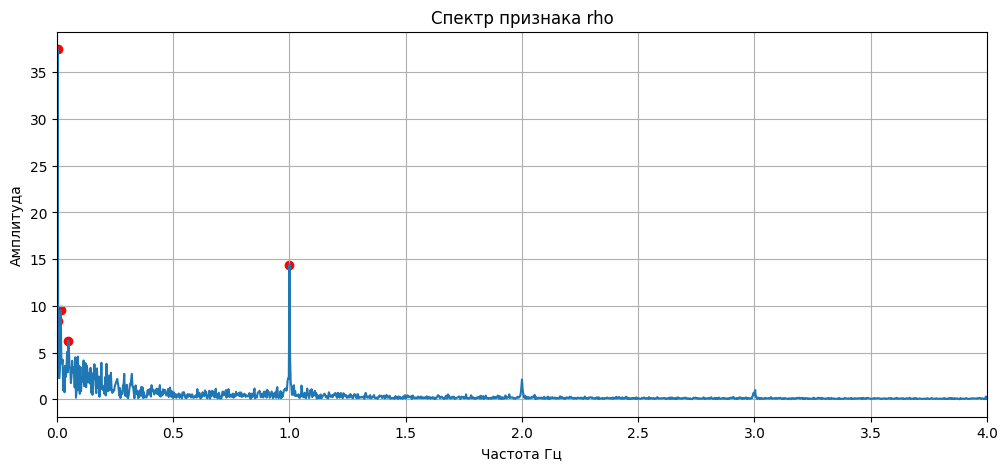


Доминирующие частоты для rho:
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 37.4701
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 14.4055
0.0164 Гц 	 период: 60.9907 day 	 Амплитуда: 9.5135
0.0055 Гц 	 период: 182.9722 day 	 Амплитуда: 8.3230
0.0492 Гц 	 период: 20.3302 day 	 Амплитуда: 6.2678


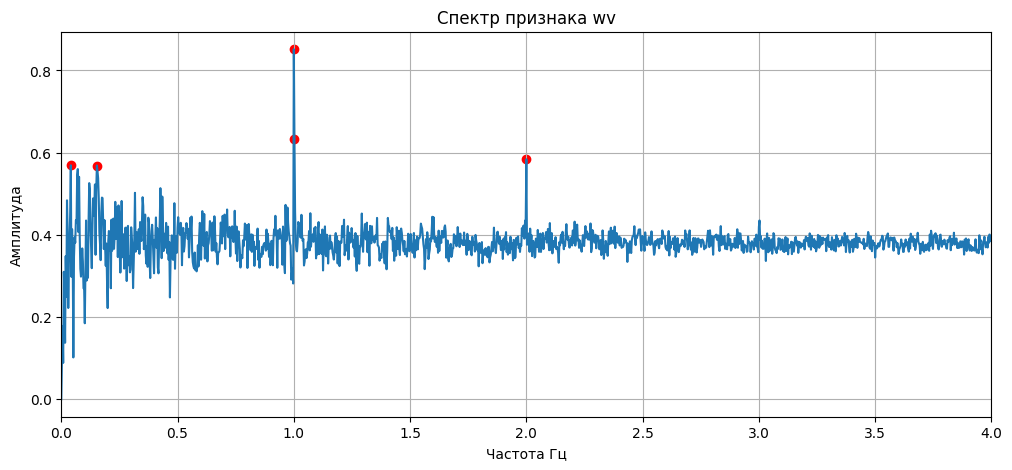


Доминирующие частоты для wv:
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 0.8515
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 0.6321
2.0003 Гц 	 период: 0.4999 day 	 Амплитуда: 0.5838
0.0410 Гц 	 период: 24.3963 day 	 Амплитуда: 0.5691
0.1530 Гц 	 период: 6.5347 day 	 Амплитуда: 0.5686


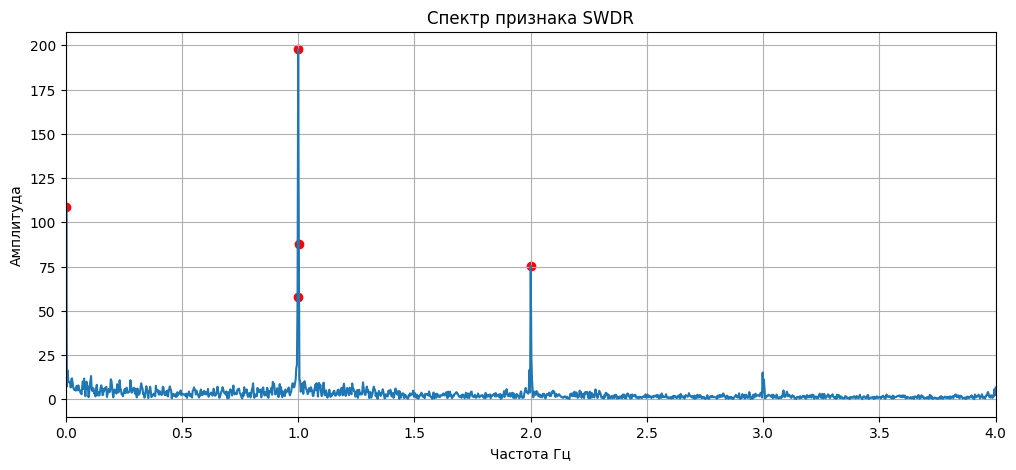


Доминирующие частоты для SWDR:
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 197.8297
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 108.8701
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 87.9288
2.0003 Гц 	 период: 0.4999 day 	 Амплитуда: 75.5589
0.9974 Гц 	 период: 1.0026 day 	 Амплитуда: 57.5561


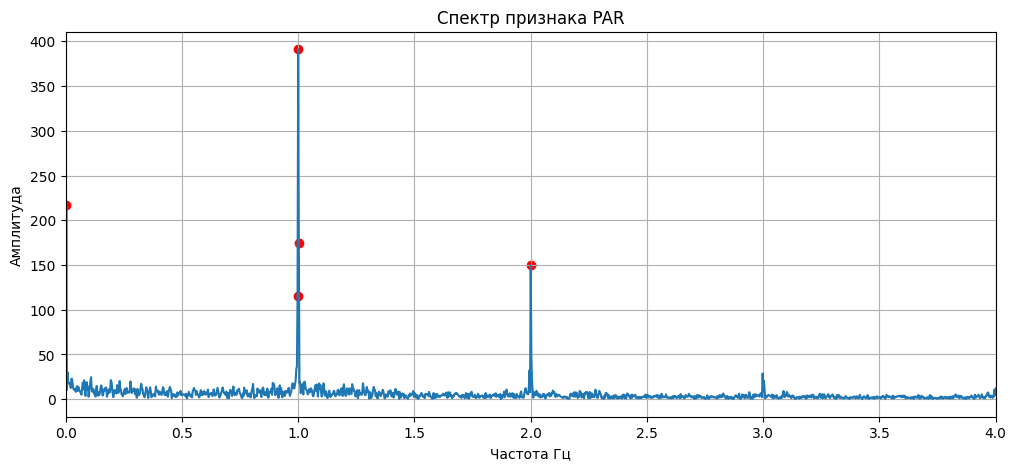


Доминирующие частоты для PAR:
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 391.1192
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 216.9351
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 174.5855
2.0003 Гц 	 период: 0.4999 day 	 Амплитуда: 149.6320
0.9974 Гц 	 период: 1.0026 day 	 Амплитуда: 115.5954


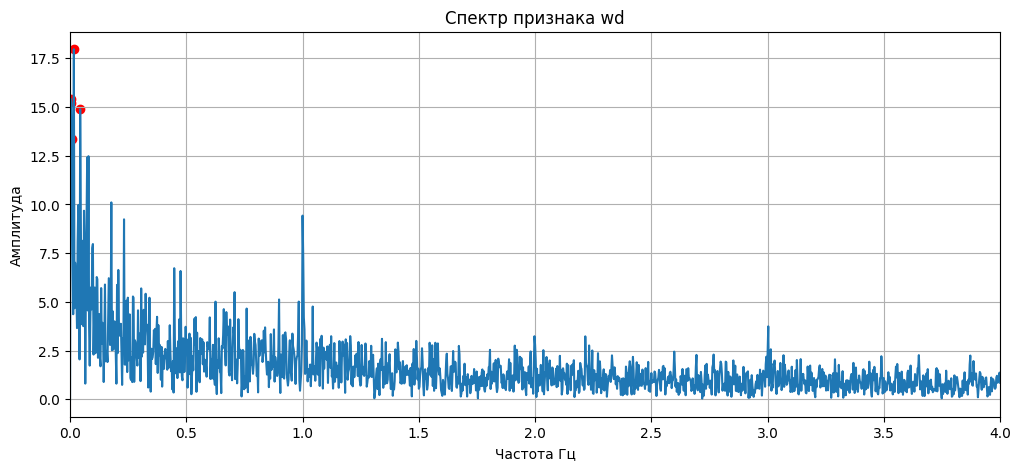


Доминирующие частоты для wd:
0.0164 Гц 	 период: 60.9907 day 	 Амплитуда: 17.9691
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 15.4213
0.0055 Гц 	 период: 182.9722 day 	 Амплитуда: 15.2090
0.0437 Гц 	 период: 22.8715 day 	 Амплитуда: 14.8862
0.0082 Гц 	 период: 121.9815 day 	 Амплитуда: 13.3575


In [15]:
# Признаки, которые, как мне кажется, фундаментальны(не выражаются через другие)
for feature in valid_cols:
    visualise_fft(df[feature], feature, 'day')

В результате анализа спектров, можно сделать выводы:
1. Выражена цикличность в 1 день, 60 дней, 180 дней
2. Для всех признаков присущ период в 365 дней, поскольку график данных за год хорошо апроксимируется синусоидой.

# Preprocessing

Значения T и Tlog очень сильно скореллированы. Судя по описанию - это температура с разных дачиков, уберем один из признаков.

In [16]:
df.drop(columns='Tlog', inplace=True)

Можно заметить, что признаки wv (скорость ветра) и max.Par (солнечная радиация) имеют отрицательные значения, такого быть не должно. К счастью, записей с такими значениями не очень много, всего около 30, заполним их ближайшим предшествуюшим значением

In [17]:
df.loc[(df['wv'] < 0), 'wv'] = np.nan
df.loc[(df['max. PAR'] < 0), 'max. PAR'] = np.nan
df = df.ffill()

Признак "время года".\
1 = зима, 2 = весна...

In [18]:
df['season'] = df['month'].apply(lambda x: (x//3)+1 if x != 12 else 1)
df = pd.get_dummies(df, columns=['season'])

Cкользящее окно для определения среднего значения для некоторых признаков

In [19]:
for feature in valid_cols:
    df[f'{feature}_mean_hour'] = df[feature].rolling(window=6,min_periods=1).mean()

    df[f'{feature}_mean_day'] = df[feature].rolling(window=SAMPLES_PER_DAY,min_periods=1).mean()

    df[f'{feature}_mean_week'] = df[feature].rolling(window=SAMPLES_PER_WEEK,min_periods=1).mean()

    df[f'{feature}_mean_month'] = df[feature].rolling(window=SAMPLES_PER_MONTH,min_periods=1).mean()

Для грамотного обучения, анализа необходим другой подход для определения направления ветра. По факту между 0 и 358 градусами разница незначительная, но для модели - колоссальная.\
Разложим направление ветра на значения двух функций - sin(x) и cos(x)

In [20]:
df['wd_cos'] = df['wd'].apply(lambda x: np.cos(x * np.pi / 180)) # Перевод в радианы
df['wd_sin'] = df['wd'].apply(lambda x: np.sin(x * np.pi / 180))

In [21]:
encoder = OrdinalEncoder()
df['wd_name_encoded'] = encoder.fit_transform(df[['wd_name']]).astype(int)

# Запись в файл

In [22]:
df.to_csv('preprocesed_df.csv', index=False)

# Разбиение на выборки

In [23]:
df = pd.read_csv('preprocesed_df.csv')
df = df.sort_values('date')
y = df['wd_name_encoded']
X = df.drop(columns=['wd', 'wd_name', 'wd_name_encoded', 'date', 'wd_cos', 'wd_sin'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_validation)

# Предсказания

Предсказания ветра в румбах не увенчалось успехом. Средняя точность на валидационной выборке = 27%

In [24]:
clf = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1, n_estimators=200)

In [25]:
clf.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,100
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
clf.score(X_train_scaled, y_train)

1.0

Выведем предсказания на графике и посчитаем метрики

In [27]:
prediction = clf.predict(X_test_scaled)
prediction = prediction.astype(int)

In [28]:
target_names = [
    'С', 'ССВ', 'СВ', 'ВСВ', 'В', 'ВЮВ', 'ЮВ', 'ЮЮВ',
    'Ю', 'ЮЮЗ', 'ЮЗ', 'ЗЮЗ', 'З', 'ЗСЗ', 'СЗ', 'ССЗ'
]
print(classification_report(y_test, prediction, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

           С       0.35      0.28      0.31       120
         ССВ       0.44      0.42      0.43       196
          СВ       0.23      0.18      0.20       116
         ВСВ       0.43      0.50      0.46       220
           В       0.26      0.16      0.20       108
         ВЮВ       0.63      0.66      0.65       556
          ЮВ       0.36      0.31      0.33       136
         ЮЮВ       0.51      0.55      0.53       340
           Ю       0.22      0.21      0.21        67
         ЮЮЗ       0.55      0.61      0.58       373
          ЮЗ       0.33      0.22      0.26        87
         ЗЮЗ       0.57      0.58      0.57       732
           З       0.28      0.27      0.28       174
         ЗСЗ       0.54      0.53      0.53       655
          СЗ       0.40      0.36      0.38       351
         ССЗ       0.61      0.66      0.64      1039

    accuracy                           0.52      5270
   macro avg       0.42   

Предсказания получились, откровенно, не очень

# Использование продвинутых алгоритмов

Реализация полносвязной нейронной сети. Несмотря на то, что такая архитектура не совсем подходит для прогнозирования временных рядов и последовательных данных, я сделал это для знакомства с библиотекой Pytorch

In [29]:
df = pd.read_csv('preprocesed_df.csv')
df = df.sort_values('date')
y = df[['wd_cos', 'wd_sin']]
X = df.drop(columns=['wd', 'wd_name', 'wd_name_encoded', 'date', 'wd_cos', 'wd_sin'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_validation)

In [30]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(dtype=np.float32), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(dtype=np.float32), dtype=torch.float32)
y_valid_tesor = torch.tensor(y_validation.to_numpy(dtype=np.float32), dtype=torch.float32)

In [31]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'

print(f'Using {device} calculations!')

Using cuda calculations!


Параметры архитектуры сети

In [32]:
window_size = SAMPLES_PER_DAY
batch_size = 128
input_size = window_size * X_train_tensor.shape[1] #размер входного слоя = кол-во записей в окне * количество признаков в записи
hidden_size = 256
output_size = 2
learning_rate = 1e-4
epochs = 70

Создание новых подвыборок тестовых данных. Каждому "окну" предшествующих данных соответствует одно значение таргета. Таким образом я хотел добиться более корерктных предсказаний, основанных на прошлом.

In [33]:
def create_windows(X, y, window_size):
    X_windows = []
    y_windows = []
    for i in range(window_size, len(X)):
        X_windows.append(X[i-window_size:i])
        y_windows.append(y[i])
    return torch.stack(X_windows), torch.stack(y_windows)

In [34]:
X_train_win, y_train_win = create_windows(X_train_tensor, y_train_tensor, window_size)
X_test_win, y_test_win = create_windows(X_test_tensor, y_test_tensor, window_size)
X_valid_win, y_valid_win = create_windows(X_valid_tensor, y_valid_tesor, window_size)

In [35]:
X_train_win.shape

torch.Size([42012, 144, 56])

In [36]:
train_dataset = TensorDataset(X_train_win, y_train_win)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_win, y_test_win)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataset = TensorDataset(X_valid_win, y_valid_win)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

Определение архитектуры модели

In [37]:
class PerceptClf(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Для корректного обучения требуется специальная функция потерь, которая будет учитывать, что сумма квадратов cos и sin равна 1.\
Pytorch позволяет определить свои функици потерь, если будут использовани поддерживаемые операторы.\
В процессе выполнения кода строится граф операций, по которому в дальнейшем будет происходить дифференцирование

In [38]:
class TrigLoss(nn.Module):
    def __init__(self, alpha=0):
        super().__init__()
        self.alpha = alpha #Коэффициент для регулирования влияния ошибки переполнения
        self.loss_fn = nn.MSELoss()

    def forward(self, prediction, target):
        main_loss = self.loss_fn(prediction, target)

        # Дополнительное ограничение sin^2 + cos^2 = 1
        sin_pred, cos_pred = prediction[:, 0], prediction[:, 1]
        overflow_err = torch.mean((sin_pred**2 + cos_pred**2 - 1)**2)

        return main_loss + self.alpha * overflow_err

Фукнция преобразования иp радиан в градусы

In [39]:
def to_degrees(cos_sin_tensor):
    cos_value = cos_sin_tensor[:, 0]
    sin_value = cos_sin_tensor[:, 1]

    radians = torch.atan2(sin_value, cos_value)
    degrees = radians * 180 / np.pi

    return (degrees % 360).view(-1, 1)

In [40]:
model = PerceptClf(input_size, hidden_size, output_size).to(device)
loss_fn = TrigLoss(alpha=0.4)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Обучение модели

In [41]:
model.train()
for epoch in tqdm(range(epochs)):
    total_loss = test_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        prediction = model(X_batch)
        loss = loss_fn(prediction, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    
    # Валидация каждые 5 эпох
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                prediction = model(X_val)
                test_loss += loss_fn(prediction, y_val).item()
        
        print(f"Train RMSE: {np.sqrt(avg_loss):.4f}\nTest RMSE: {np.sqrt(test_loss/len(test_loader)):.4f}")
        model.train()

  7%|▋         | 5/70 [00:06<01:20,  1.23s/it]

Train RMSE: 0.5090
Test RMSE: 0.4725


 14%|█▍        | 10/70 [00:12<01:12,  1.21s/it]

Train RMSE: 0.4785
Test RMSE: 0.5050


 21%|██▏       | 15/70 [00:18<01:06,  1.21s/it]

Train RMSE: 0.4618
Test RMSE: 0.4376


 29%|██▊       | 20/70 [00:24<01:00,  1.21s/it]

Train RMSE: 0.4479
Test RMSE: 0.4518


 36%|███▌      | 25/70 [00:30<00:55,  1.23s/it]

Train RMSE: 0.4386
Test RMSE: 0.4317


 43%|████▎     | 30/70 [00:36<00:48,  1.21s/it]

Train RMSE: 0.4284
Test RMSE: 0.4170


 50%|█████     | 35/70 [00:42<00:42,  1.22s/it]

Train RMSE: 0.4226
Test RMSE: 0.4194


 57%|█████▋    | 40/70 [00:48<00:38,  1.28s/it]

Train RMSE: 0.4153
Test RMSE: 0.4337


 64%|██████▍   | 45/70 [00:54<00:30,  1.24s/it]

Train RMSE: 0.4113
Test RMSE: 0.4176


 71%|███████▏  | 50/70 [01:00<00:24,  1.24s/it]

Train RMSE: 0.4045
Test RMSE: 0.4087


 79%|███████▊  | 55/70 [01:07<00:18,  1.26s/it]

Train RMSE: 0.4007
Test RMSE: 0.4053


 86%|████████▌ | 60/70 [01:13<00:12,  1.25s/it]

Train RMSE: 0.3949
Test RMSE: 0.3951


 93%|█████████▎| 65/70 [01:19<00:06,  1.27s/it]

Train RMSE: 0.3899
Test RMSE: 0.4100


100%|██████████| 70/70 [01:25<00:00,  1.22s/it]

Train RMSE: 0.3877
Test RMSE: 0.3986


Валидация

In [42]:
def validate(loader, model):
    loss_fn = nn.MSELoss()
    predictions = []
    model.eval()
    total_mse = 0
    with torch.no_grad():
        for X_val, y_val in loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            prediction = model(X_val)
            degree_prediction = to_degrees(prediction)
            predictions.extend(degree_prediction.cpu().flatten().tolist())
            total_mse += loss_fn(prediction, y_val).item()
    
    return predictions

In [43]:
predictions = validate(valid_loader, model)
target = to_degrees(y_valid_win).cpu().flatten().tolist()

In [44]:
loss_fn = nn.MSELoss()
pred_tensor = torch.tensor(predictions).view(-1, 1)
target_tensor = torch.tensor(target).view(-1, 1)
valid_loss = np.sqrt(loss_fn(pred_tensor, target_tensor).item())

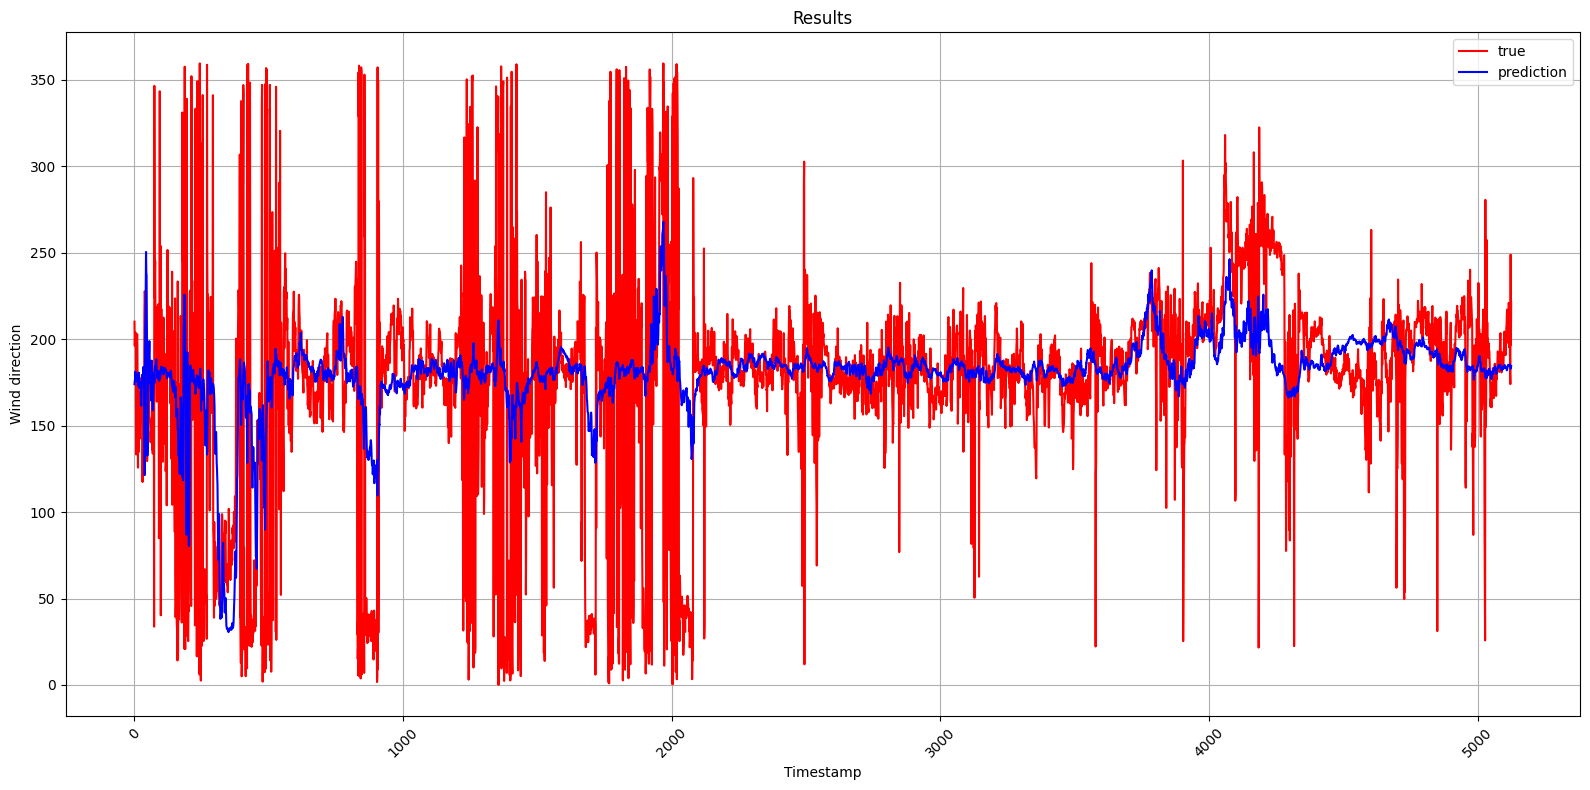

In [45]:
plt.figure(figsize=(16, 8))
plt.plot(range(0,len(target)), target, linestyle='-', color='red')
plt.plot(range(0,len(target)), predictions, linestyle='-', color='blue')

plt.xlabel('Timestamp')
plt.ylabel('Wind direction')
plt.legend(['true', 'prediction'])
plt.title('Results')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
print(valid_loss)

56.002336725801


58.97005827907498

Разбиение значения "направления ветра" на sin cos помого снизить ошибку на ~ 30%

In [47]:
#%reset